In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np

# Input file paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
envi_raster_path = "non_provisional_flightlines/NEON_D13_NIWO_DP1_20200801_155424_reflectance/NEON_D13_NIWO_DP1_20200801_155424_reflectance"
output_masked_raster_path = "masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat"

# Load the GeoJSON file with polygons
polygons = gpd.read_file(geojson_path)

# Open the ENVI raster file
with rasterio.open(envi_raster_path) as src:
    # Read the metadata and data
    meta = src.meta.copy()
    raster_data = src.read(1)  # Assuming single-band raster, adjust if multi-band
    
    # Create a mask based on the GeoJSON polygons
    mask = geometry_mask(
        [geom for geom in polygons.geometry],
        transform=src.transform,
        invert=True,  # Keep pixels inside the polygons
        out_shape=(src.height, src.width),
    )
    
    # Apply the mask to the raster data
    masked_raster = np.where(mask, raster_data, np.nan)  # Set masked areas to NaN

# Update metadata for the output raster
meta.update(dtype='float32', nodata=np.nan)

# Save the masked raster to a new ENVI file
with rasterio.open(output_masked_raster_path, 'w', **meta) as dst:
    dst.write(masked_raster.astype('float32'), 1)

print(f"Masked raster saved to {output_masked_raster_path}")


Masked raster saved to masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat


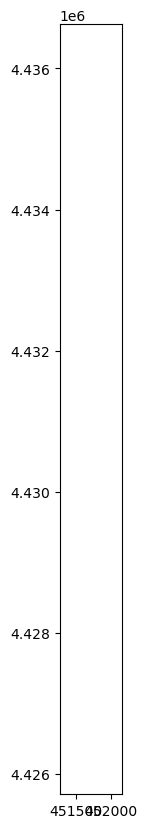

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

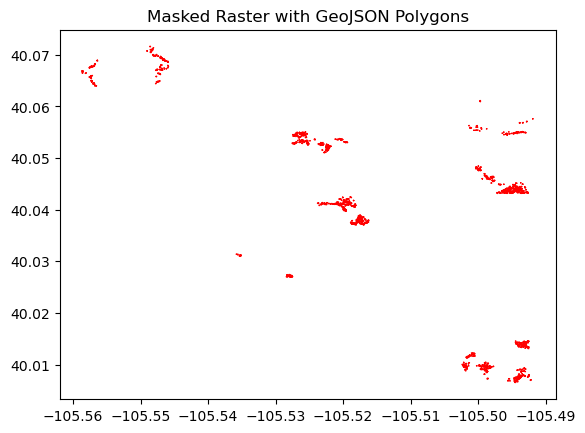

In [2]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# File paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
masked_raster_path = "masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat"

# Load the GeoJSON file
polygons = gpd.read_file(geojson_path)

# Open the masked raster file
with rasterio.open(masked_raster_path) as src:
    # Read the first band for visualization (adjust if needed)
    raster_data = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 10))
    show(raster_data, transform=src.transform, cmap="viridis")
    plt.title("Masked Raster with GeoJSON Polygons")
    
    # Overlay the polygons
    for geom in polygons.geometry:
        if not geom.is_empty:
            x, y = geom.exterior.xy  # Extract exterior boundary of the polygon
            plt.plot(x, y, color="red", linewidth=1, label="Polygon Overlay")
    
    # Add legend and display
    plt.legend(["GeoJSON Polygons"])
    plt.show()
